# 0. Instructions and setup

## 0.1. Instructions. Part 2: Data Scientist Challenge (3.5 points)

- **Objective:** Explore different techniques to enhance model performance with limited  labeled data. You will be limited to 32 labeled examples in your task.  The rest can be viewed as unlabelled data. 

- **Tasks:**
  - **a. BERT Model with Limited Data (0.5 points):** Train a BERT-based model using only 32 labeled examples and assess its performance.
  - **b. Dataset Augmentation (1 point):** Experiment with an automated technique to increase your dataset size **without using LLMs** (chatGPT / Mistral / Gemini / etc...). Evaluate the impact on model performance.
  - **c. Zero-Shot Learning with LLM (0.5 points):** Apply a LLM (chatGPT/Claude/Mistral/Gemini/...) in a zero-shot learning setup. Document the performance.
  - **d. Data Generation with LLM (1 point):** Use a LLM (chatGPT/Claude/Mistral/Gemini/...) to generate new, labeled  dataset points. Train your BERT model with it + the 32 labels. Analyze  how this impacts model metrics.
  - **e. Optimal Technique Application (0.5 points):** Based on the previous experiments, apply the most effective  technique(s) to further improve your model's performance. Comment your results and propose improvements.

## 0.2. Libraries

In [1]:
# !pip install polars  # Install polars for faster data processing

In [2]:
from datasets import load_dataset
from pprint import pprint
import polars as pl
from library.metrics import Metrics
from library.utilities import set_seed
import torch 
import tqdm.notebook as tqdm

In [3]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.3590, 0.7035, 0.4713],
        [0.6689, 0.1912, 0.9507],
        [0.7940, 0.2419, 0.0603],
        [0.7771, 0.2834, 0.9313],
        [0.1609, 0.7976, 0.7314]])


In [4]:
torch.version.cuda()

TypeError: 'str' object is not callable

In [ ]:
# Initialize the metrics object to save the results
metrics = Metrics()

In [5]:
# Check the availability of a GPU
torch.cuda.is_available()

True

## 0.3. Random Seed

In [9]:
# Set random seed for reproducibility
seed = 42
set_seed(42)

Seed set to 42. This ensures reproducibility of results across runs.


## 0.4. Loading the data: Swiss Judgement Prediction

Source: https://huggingface.co/datasets/rcds/swiss_judgment_prediction

In [10]:
# Load the cleaned Parquet file
df = pl.read_parquet('swiss_judgment_prediction_fr&it_clean.parquet')

# Display the loaded DataFrame
print("\nLoaded DataFrame shape:", df.shape)
print("\nLoaded DataFrame schema:")
print(df.schema)
print("\nFirst few rows of the loaded DataFrame:")
df.head()


Loaded DataFrame shape: (35386, 9)

Loaded DataFrame schema:
Schema({'id': Int32, 'year': Int32, 'text': String, 'label': Int64, 'language': String, 'region': String, 'canton': String, 'legal area': String, 'split': String})

First few rows of the loaded DataFrame:


id,year,text,label,language,region,canton,legal area,split
i32,i32,str,i64,str,str,str,str,str
22014,2011,"""Faits: A. Le 28 octobre 2002 à…",0,"""fr""","""Région lémanique""","""ge""","""civil law""","""train"""
11593,2007,"""Faits : Faits : A. Le 17 avril…",1,"""fr""","""Région lémanique""","""ge""","""penal law""","""train"""
26670,2013,"""Faits: A. Par jugement du 2 ma…",0,"""fr""","""Région lémanique""","""vd""","""penal law""","""train"""
5864,2004,"""Faits: Faits: A. N._, née en 1…",1,"""fr""","""Région lémanique""","""vd""","""insurance law""","""train"""
16122,2009,"""Faits: A. Y._ est propriétaire…",0,"""fr""","""Région lémanique""","""ge""","""public law""","""train"""


In [11]:
french_texts = df.filter((pl.col('language') == 'fr'))

# 1. BERT Model with Limited Data

Outline of the intermediate tasks:

1. Preprocessing Pipeline
   - Lowercasing, punctuation stripping (or not, depending on BERT tokenizer).
   - Sentencepiece/BPE tokenization via the CamemBERT (for French) or UmBERTo (for Italian).
   - (Optional) language tags if you merge FR+IT in one model.
2. Hold-out Split. Since you only have 32 labels: use stratified k-fold CV (e.g. 8 × 4-fold) to get reliable estimates, or leave-one-out if you want maximum training data per fold.
3. BERT Model with Only 32 Examples
   - Model Choice: Pick a multilingual BERT (mBERT) or separate CamemBERT/UmBERTo checkpoint. Alternatives:
     - Multilingual/monolingual models:
       -  [BERT multilingual base model (cased)](https://huggingface.co/google-bert/bert-base-multilingual-cased). Paper: "[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)". 
       -  [CamemBERT 2.0](https://huggingface.co/almanach/camembertv2-base) and [CamemBERTav2](https://huggingface.co/almanach/camembertav2-base), models trained with French text and explained in the paper: [CamemBERT 2.0: A Smarter French Language Model Aged to Perfection](https://arxiv.org/html/2411.08868v1#S3). These models supposedly improve over the performance of the original [CamemBERT](https://huggingface.co/docs/transformers/en/model_doc/camembert) model, explained in "[CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894)".
       -  [FlauBERT](https://huggingface.co/docs/transformers/en/model_doc/flaubert), another model pre-trained on French text. Paper: "[FlauBERT: Unsupervised Language Model Pre-training for French](https://arxiv.org/abs/1912.05372)". 
       -  [BERT Base Italian Uncased](https://huggingface.co/dbmdz/bert-base-italian-uncased), [Cased](https://huggingface.co/dbmdz/bert-base-italian-cased),and [XXL Uncased](https://huggingface.co/dbmdz/bert-base-italian-xxl-uncased). 
       -  [UmBERTo Commoncrawl Cased](https://huggingface.co/Musixmatch/umberto-commoncrawl-cased-v1), another model trained with a large corpus of texts in Italian.
      -  Domain-specific models (law):
          - [LEGAL-BERT](https://huggingface.co/nlpaueb/legal-bert-base-uncased) does not seem to be a good option as it was trained only on English data.
          - [JuriBERT](https://huggingface.co/dascim/juribert-base) for legal texts in French. Paper explaining the model: [JuriBERT: A Masked-Language Model Adaptation for French Legal Text](https://arxiv.org/pdf/2110.01485).
          - [ITALIAN-LEGAL-BERT](https://huggingface.co/dlicari/Italian-Legal-BERT) for legal text in Italian. Paper explaining the model: [ITALIAN-LEGAL-BERT models for improving natural language processing tasks in the Italian legal domain](https://www.sciencedirect.com/science/article/pii/S0267364923001188).
   - Fine-tuning Setup.
     - Freeze or unfreeze last n encoder layers—try both.
     - Small learning rate (2e-5 – 5e-5), batch size = 8 or 16.
     - Early stopping on validation loss.
4. Training & Evaluation
    - Run your k-fold CV training loops.
    - Track accuracy, F1, precision, recall per fold.
    - Report mean ± std.
5. Error Analysis and feature interpretation.
    - Use `LIME` for analyzing the most relevant features for classifying the texts. 
    - Look at which examples are mispredicted.
    - Check language breakdown (FR vs. IT) to see if one is harder.

## 1.1. Standard fine-tuning

Notebook of reference: `Session_5_1_BERT_HF_Implementation.ipynb`, sections 1, 2 and 5.

## 1.2. Using SetFit ("Sentence Transformer Fine-Tuning")

Notebook of reference: `Session_6_2_Zero_Shot_Classification.ipynb`, introduction, step 1 (loading data) and step 6 ("Few-Shot Classification with SetFit").

Applying SetFit (the “Sentence Transformer Fine-Tuning” recipe) absolutely counts as **training** (it fine-tunes a pre-trained sentence-embedding model, plus fits a small classifier on top). And indeed, SetFit was built **for** the exactly your scenario—getting strong performance with as few as a few dozen labeled examples.

---

**Why SetFit = Training**

* **Contrastive fine-tuning:**
  You start with a frozen (or lightly unfrozen) Sentence-Transformer model and then *fine-tune* it on automatically generated sentence pairs derived from your 32 labels.
* **Classifier head training:**
  After contrastive tuning, you fit a lightweight logistic-regression (or small MLP) classifier on the resulting embeddings.
* Both steps update model parameters—so it’s training/fine-tuning, not mere prompt-engineering or zero-shot.

---

**Why SetFit excels in limited-label regimes**

1. **Data amplification via contrastive pairs**

   * From each labeled example, SetFit creates positive pairs (e.g. two different augmentations of the same sentence) and negative pairs (across classes), turning 32 labels into hundreds or thousands of pairwise signals.
   * That extra signal helps the embedding space separate classes, even when you only have a few “gold” labels.

2. **Lightweight classifier**

   * Because the embedding model has already been tuned to distinguish your classes, the final classifier can be a simple logistic or MLP—so it needs very few examples to learn decision boundaries.

3. **Empirical few-shot strength**

   * In benchmarks, SetFit often outperforms standard BERT fine-tuning when you have <100 labels, and it’s much faster to train (no full back-prop through all BERT layers).

---

**How to plug SetFit into the task**

1. **Install** the SetFit library (e.g. via `pip install setfit`).
2. **Initialize** a pre-trained checkpoint:

   ```python
   from setfit import SetFitModel, SetFitTrainer
   model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
   ```
3. **Prepare** your 32 labeled examples as `(text, label)` tuples.
4. **Train** the model:

   ```python
   trainer = SetFitTrainer(
       model=model,
       train_dataset=my_32_examples,
       eval_dataset=my_dev_split,
       metric="accuracy",
       loss="cosine-similarity",
       batch_size=16,
       num_iterations=20,          # controls number of contrastive steps
       num_epochs=1                # just one pass for the classifier
   )
   trainer.train()
   ```
5. **Evaluate** on your held-out data.

You’ll have fine-tuned embeddings *and* a classifier head—all with only 32 labels. That makes SetFit not just “considered training,” but *one of the best* training-with-few-labels recipes out there.


# 2. Dataset Augmentation

Outline of the intermediate tasks: We want a fully automated pipeline. A good candidate is Easy Data Augmentation (EDA) or back-translation via open‐source MT models.
1. Choose Technique(s)
   - EDA: random synonym substitution (WordNet or fastText), random swap, insertion, deletion.
   - Back-translation: FR → EN → FR and IT → EN → IT using MarianMT or opus-MT.
2. Implement & Generate
   - For each of the 32 labeled examples, generate k augmented pseudo-examples (e.g. k=5).
   - Deduplicate and filter (e.g. reject if new text <50% overlap).
3. Merge & Re-split
   - Combine original 32 + synthetic N = 32×k examples.
   - Re-run the same CV split strategy, ensuring augmented copies of a given original stay in the same fold.
4. Re-train BERT
   - Exactly the same hyperparams as in (a).
   - Track performance uplift vs. the baseline.
5. Analysis
   - Compare metrics: ΔAccuracy, ΔF1.
   - Ablation: EDA vs. back-translation vs. combined.
   - Qualitative: inspect a few synthetic samples.

# 3. Zero-Shot Learning with LLM

### Select balanced dataset samples (16 from each class)

In [7]:
def select_balanced_samples(df, n_samples=32):
    class_0_samples = df.filter((pl.col('label') == 0) & (pl.col('split') == 'train')).sample(n_samples/2)
    class_1_samples = df.filter((pl.col('label') == 1) & (pl.col('split') == 'train')).sample(n_samples/2)

    labeled_samples = pl.concat([class_0_samples, class_1_samples])
    return labeled_samples

labeled_data = select_balanced_samples(df, n_samples=32)
print(f"Selected {len(labeled_data)} labeled examples")

Selected 32 labeled examples


### Activate Groq client for LLM API access

In [ ]:
import os
from groq import Groq
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

groq_api_key = os.getenv("GROQ_API_KEY")
client = Groq(api_key=groq_api_key)
MODEL_NAME = "deepseek-r1-distill-llama-70b"

### Create zero-shot prompts

In [ ]:
def create_legal_prompt(case_text):
    prompt = f"""Vous êtes un juriste qui analyse des affaires du Tribunal fédéral suisse. Les textes sont en français. Vous devez déterminer la langue à partir du texte.
    En vous basant uniquement sur les faits de l'affaire ci-dessous, déterminez si l'affaire doit être rejetée (0) ou approuvée (1).
    
    Le rejet (0) signifie que le recours est rejeté
 L'approbation (1) signifie que le recours est accepté.
    
    Faits de l'affaire :
    {case_text}
    
    Analysez le cas et répondez par un seul chiffre : 0 pour le rejet ou 1 pour l'approbation.
    """
    return prompt

def classify_case(case_text):
    prompt = create_legal_prompt(case_text)
    
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=1000
        )
    
        prediction_text = response.choices[0].message.content.strip() # extract the label from response, look for 0 or 1
        if "0" in prediction_text:
            return 0
        elif "1" in prediction_text:
            return 1
        else:
            return 0 # default majority class
            
    except Exception as e:
        print(f"Error in API call: {e}")
        return 0 # again majority class

### Process some samples

In [15]:
import time

def process_batch(df, batch_size=10):
    y_pred = []
    y_true = []
    
    for i in range(0, len(df), batch_size):
        batch = df.slice(i, min(batch_size, len(df) - i))
        
        for case in tqdm.tqdm(batch.iter_rows(named=True)):
            y_true.append(case['label'])
            prediction = classify_case(case['text'])
            y_pred.append(prediction)            
            #time.sleep(0.5) # avoid API rate limits
            
    return y_true, y_pred

### Evaluate on test set

Classifying samples from the test set...


0it [00:00, ?it/s]

Metrics calculated for: zero_shot_llm

Metrics for zero_shot_llm

Accuracy: 70.00%

Precision: 0.00%

Recall: 0.00%

F1 Score: 0.00%


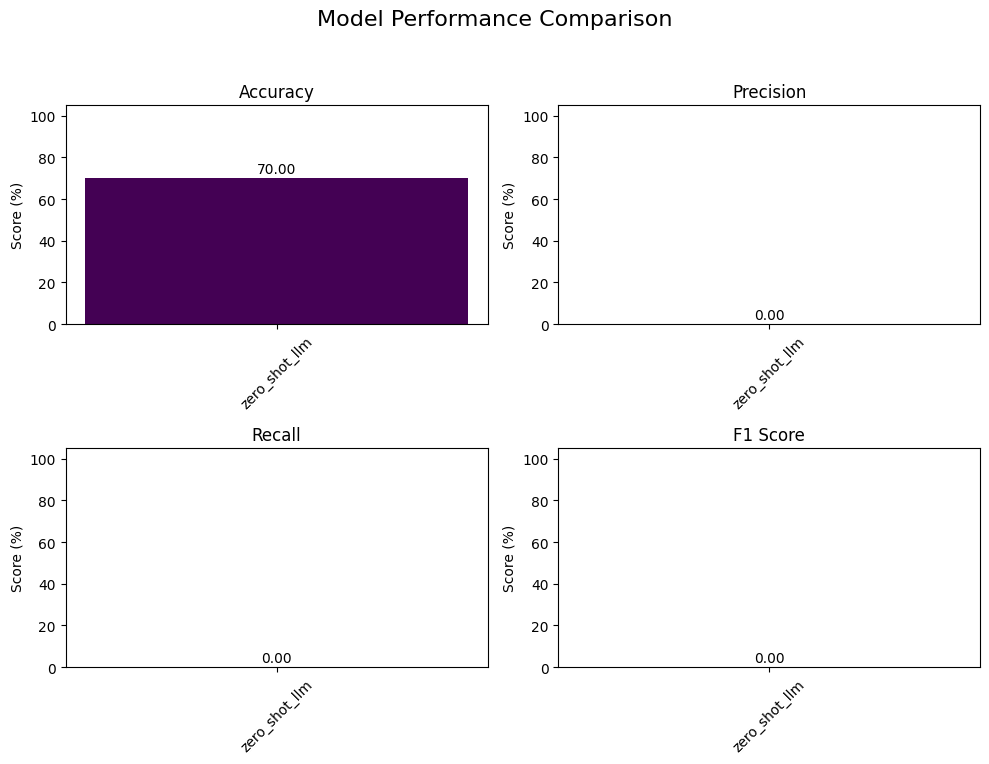

In [ ]:
test_samples = french_texts.filter(pl.col('split') == 'test').sample(100)

print("Classifying samples from the test set...")
y_true, y_pred = process_batch(test_samples)

# Calculate metrics
metrics.run(y_true, y_pred, f'zero_shot_llm', average='binary')

# print results of zero-shot LLM classification
metrics.print_results()
metrics.plot()

## With Gemini API

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
model = AutoModelForCausalLM.from_pretrained("google/gemma-7b")

OSError: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [20]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load model and tokenizer
model_name = "google/gemma-7b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model loaded on {device}")

OSError: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

# 4. Data Generation with LLM

# 5. Optimal Technique Application